In [ ]:
# Install necessary libraries
!pip install transformers torch datasets wandb accelerate

import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import softmax
import wandb
from accelerate import Accelerator

# Initialize Weights and Biases
wandb.init(project="bert_intent_classifier", config={"batch_size": 16, "epochs": 1, "lr": 5e-5})


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

# Step 1: Load the BANKING77 dataset
banking_data = load_dataset("banking77")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    banking_data["train"]["text"],
    banking_data["train"]["label"],
    test_size=0.2,
    random_state=42,
)

# Retrieve intent names
intent_classes = banking_data["train"].features["label"].names
intent_classes.append("irrelevant")  # Add the "irrelevant" class for open intents


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:

# Step 2: Define custom dataset class
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label),
            "text": text,
        }

# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Prepare datasets and dataloaders
train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
test_dataset = IntentDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=wandb.config.batch_size)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:

# Step 3: Define the BERT RAG Model
class BERTIntentClassifierWithRAG(nn.Module):
    def __init__(self, num_labels, knowledge_base, tokenizer):
        super(BERTIntentClassifierWithRAG, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size * 2, num_labels)
        self.knowledge_base = knowledge_base
        self.tokenizer = tokenizer

        # Precompute knowledge base embeddings
        self.kb_embeddings = self.encode_texts(self.knowledge_base)

    def encode_texts(self, texts):
        inputs = self.tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            embeddings = self.bert(**inputs).last_hidden_state[:, 0, :]
        return embeddings

    def retrieve(self, query):
        query_embedding = self.encode_texts([query]).to(self.kb_embeddings.device)
        scores = torch.nn.functional.cosine_similarity(query_embedding, self.kb_embeddings, dim=1)
        top_index = scores.argmax().item()
        return self.knowledge_base[top_index]

    def forward(self, input_ids, attention_mask, query_texts):
        query_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        retrieved_texts = [self.retrieve(q) for q in query_texts]
        retrieved_inputs = self.tokenizer(retrieved_texts, return_tensors="pt", padding=True, truncation=True)
        retrieved_outputs = self.bert(**retrieved_inputs).last_hidden_state[:, 0, :]
        combined = torch.cat([query_outputs, retrieved_outputs], dim=1)
        logits = self.classifier(combined)
        return logits


In [ ]:

# Step 4: Initialize model, optimizer, and loss function
knowledge_base = intent_classes[:-1]
num_labels = len(intent_classes)
model = BERTIntentClassifierWithRAG(num_labels, knowledge_base, tokenizer)

# Mixed precision and accelerator setup
accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_loader = accelerator.prepare(
    model,
    torch.optim.AdamW(model.parameters(), lr=wandb.config.lr),
    train_loader,
)

criterion = nn.CrossEntropyLoss()


In [ ]:

# Step 5: Train the model
epochs = wandb.config.epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(accelerator.device)
        attention_mask = batch["attention_mask"].to(accelerator.device)
        labels = batch["label"].to(accelerator.device)
        query_texts = batch["text"]

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask, query_texts=query_texts)
        loss = criterion(logits, labels)
        accelerator.backward(loss)
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    wandb.log({"epoch": epoch + 1, "loss": total_loss})

    # Save model periodically
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    torch.save(unwrapped_model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")
    wandb.save(f"checkpoint_epoch_{epoch+1}.pth")

wandb.finish()


Epoch 1/1, Loss: 858.1331


epoch,▁
loss,▁
epoch,1
loss,858.13312


In [ ]:
def test_accuracy(test_loader, model, accelerator):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(accelerator.device)
            attention_mask = batch["attention_mask"].to(accelerator.device)
            labels = batch["label"].to(accelerator.device)
            query_texts = batch["text"]

            # Get model predictions
            logits = model(input_ids=input_ids, attention_mask=attention_mask, query_texts=query_texts)
            preds = torch.argmax(logits, dim=1)

            # Accumulate correct predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [ ]:
# Prepare test loader for mixed precision
test_loader = accelerator.prepare(test_loader)

# Evaluate and log accuracy
accuracy = test_accuracy(test_loader, model, accelerator)
wandb.log({"test_accuracy": accuracy})


Test Accuracy: 86.71%


In [ ]:
unwrapped_model = accelerator.unwrap_model(model)
torch.save(unwrapped_model.state_dict(), "final_model.pth")
wandb.save("final_model.pth")


['/content/wandb/run-20241118_025305-4e6wk85c/files/final_model.pth']

In [ ]:
# Step 8: Define the classify_query function
def classify_query(query, model, tokenizer, knowledge_base, device, confidence_threshold=0.8):
    model.eval()
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], query_texts=[query])
        probs = softmax(logits, dim=1)
        max_prob, pred_label = torch.max(probs, dim=1)

        if max_prob.item() < confidence_threshold:
            return "Irrelevant query"
        else:
            return knowledge_base[pred_label.item()]

# Test with example queries
query1 = "How do I reset my password?"
query2 = "What's the best pizza place nearby?"

print(f"Query: {query1}, Classified as: {classify_query(query1, model, tokenizer, knowledge_base, accelerator.device)}")
print(f"Query: {query2}, Classified as: {classify_query(query2, model, tokenizer, knowledge_base, accelerator.device)}")

Query: How do I reset my password?, Classified as: passcode_forgotten
Query: What's the best pizza place nearby?, Classified as: Irrelevant query


In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), 'model_weights_RAG.pth')

In [ ]:
model = BERTIntentClassifierWithRAG(num_labels, knowledge_base, tokenizer)
model.load_state_dict(torch.load('model_weights_RAG.pth'))
model.eval()


<ipython-input-10-999933a9d3b8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights_RAG.pth'))


BERTIntentClassifierWithRAG(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

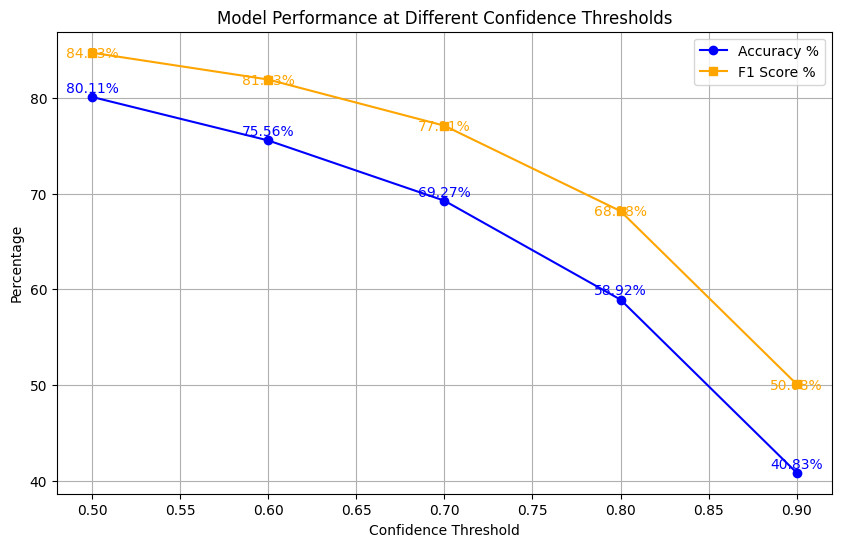

In [ ]:
# Ensure classify_query is defined here or earlier
def classify_query(query, model, tokenizer, knowledge_base, device, confidence_threshold=0.8):
    model.eval()
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], query_texts=[query])
        probs = softmax(logits, dim=1)
        max_prob, pred_label = torch.max(probs, dim=1)

        if max_prob.item() < confidence_threshold:
            return "Irrelevant query"
        else:
            return knowledge_base[pred_label.item()]

# Updated test_metrics function
def test_metrics(test_loader, model, accelerator, knowledge_base, tokenizer, threshold):
    from sklearn.metrics import f1_score  # Ensure sklearn is imported
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(accelerator.device)
            attention_mask = batch["attention_mask"].to(accelerator.device)
            labels = batch["label"].to(accelerator.device)
            query_texts = batch["text"]

            # Get model predictions with custom classify_query logic
            for i, query in enumerate(query_texts):
                predicted_label = classify_query(
                    query=query,
                    model=model,
                    tokenizer=tokenizer,
                    knowledge_base=knowledge_base,
                    device=accelerator.device,
                    confidence_threshold=threshold
                )
                y_true.append(labels[i].item())
                if predicted_label == "Irrelevant query":
                    y_pred.append(len(knowledge_base))  # Irrelevant class
                else:
                    y_pred.append(knowledge_base.index(predicted_label))

    accuracy = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]]) / len(y_true)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return accuracy * 100, f1 * 100

# Proceed to test for different thresholds
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []
f1_scores = []

for threshold in thresholds:
    accuracy, f1 = test_metrics(test_loader, model, accelerator, knowledge_base, tokenizer, threshold)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label="Accuracy %", marker="o", color='blue')
plt.plot(thresholds, f1_scores, label="F1 Score %", marker="s", color='orange')

# Annotate points with their values
for i, threshold in enumerate(thresholds):
    plt.text(threshold, accuracies[i] + 0.5, f"{accuracies[i]:.2f}%", ha='center', color='blue')
    plt.text(threshold, f1_scores[i] - 0.5, f"{f1_scores[i]:.2f}%", ha='center', color='orange')

plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage")
plt.title("Model Performance at Different Confidence Thresholds")
plt.legend()
plt.grid()
plt.show()
